### Importing Necessary Libraries and Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Download VADER lexicon for sentiment analysis
try:
    # Set download location to prevent permissions issues in some environments
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    nltk.download('vader_lexicon', quiet=True)
except Exception as e:
    print(f"Warning: NLTK download failed. Ensure NLTK is installed. Error: {e}")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = '/content/test.csv'
df = pd.read_csv(file_path)

print(f"Initial Dataset Shape: {df.shape}")
df.head(2)

Initial Dataset Shape: (2191, 4)


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com


### Data Cleaning and Sentiment Labeling

In [2]:
# Convert date column to datetime objects and handle missing dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date', 'from'], inplace=True) # Ensure 'date' and 'from' are present

# Combine Subject and body for comprehensive text analysis
df['text'] = df['Subject'].fillna('') + ' ' + df['body'].fillna('')

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower()
    # Remove special entities like emails and URLs, then remove punctuation
    text = re.sub(r'\S+@\S+', ' email_address ', text)
    text = re.sub(r'http\S+', ' url ', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Initialize VADER and apply sentiment scoring
vader = SentimentIntensityAnalyzer()
df['compound'] = df['cleaned_text'].apply(lambda text: vader.polarity_scores(text)['compound'])

# Function to label sentiment (Positive, Negative, Neutral)
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['compound'].apply(label_sentiment)

print("Sentiment Labeling Complete.")
df[['date', 'Subject', 'compound', 'sentiment_label']].sample(5)

Sentiment Labeling Complete.


,date,Subject,compound,sentiment_label
2164,2010-03-01,Congrats,0.8074,Positive
1811,2010-12-12,(No Subject),0.5106,Positive
1140,2011-02-13,Re: Greg's Bill,-0.3412,Negative
87,2010-04-08,Trade,-0.2584,Negative
1188,2010-03-14,Associate Starting,0.8948,Positive


### EDA and Data Visualizations

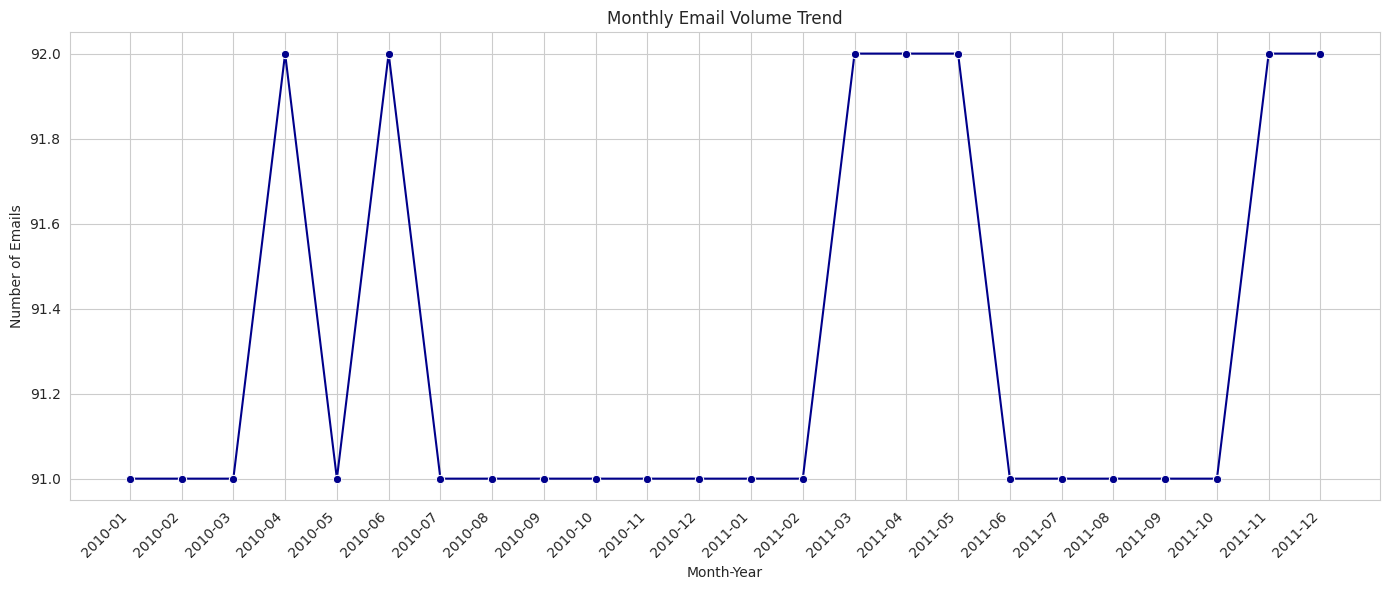

/tmp/ipython-input-3630372076.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values,


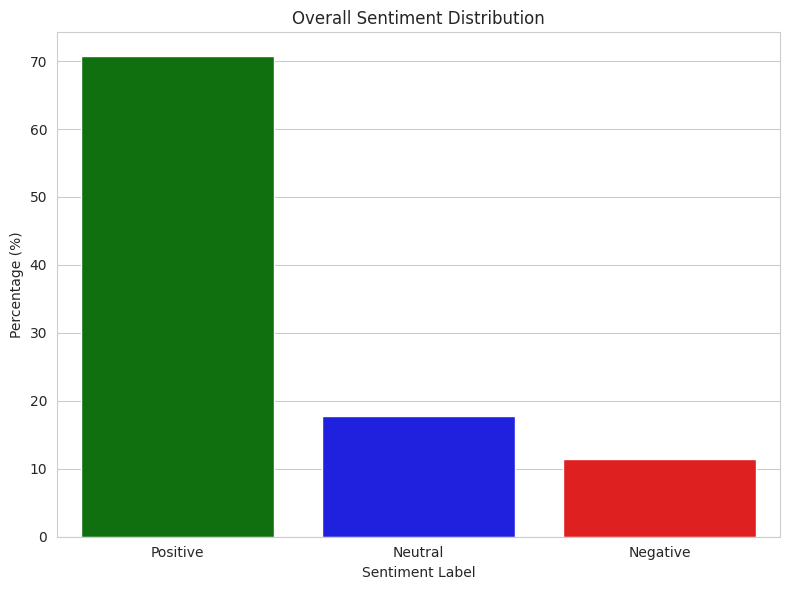

In [6]:
df['month_year'] = df['date'].dt.to_period('M')
sns.set_style("whitegrid")

# a) Monthly Email Volume Trend
monthly_volume = df.groupby('month_year').size().reset_index(name='Volume')
monthly_volume['month_year'] = monthly_volume['month_year'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(x='month_year', y='Volume', data=monthly_volume, marker='o', color='darkblue')
plt.title('Monthly Email Volume Trend')
plt.xlabel('Month-Year')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('email_volume_trend.png')
plt.show()

# b) Overall Sentiment Distribution
plt.figure(figsize=(8, 6))
sentiment_counts = df['sentiment_label'].value_counts(normalize=True) * 100
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values,
            palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'})

plt.title('Overall Sentiment Distribution')
plt.ylabel('Percentage (%)')
plt.xlabel('Sentiment Label')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

### Monthly Sentiment Scoring

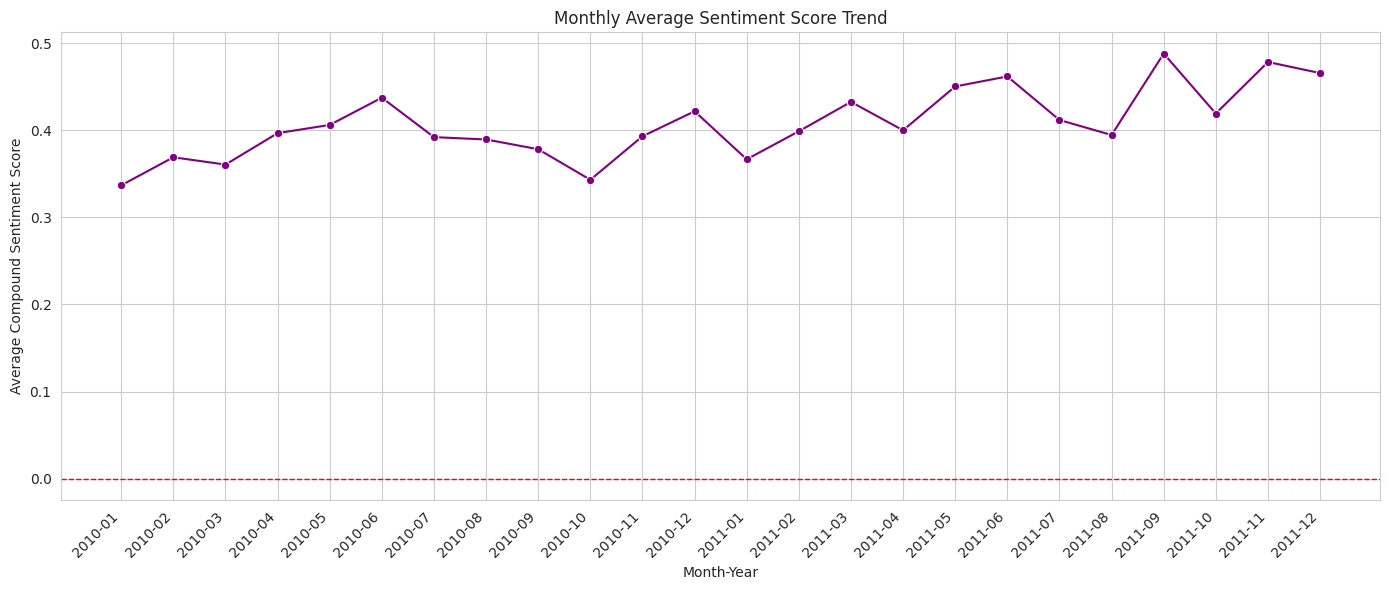

In [8]:
# Calculate the average (mean) compound sentiment score per month
monthly_sentiment = df.groupby('month_year')['compound'].mean().reset_index(name='Average_Sentiment')
monthly_sentiment['month_year'] = monthly_sentiment['month_year'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(x='month_year', y='Average_Sentiment', data=monthly_sentiment, marker='o', color='purple')
plt.title('Monthly Average Sentiment Score Trend')
plt.xlabel('Month-Year')
plt.ylabel('Average Compound Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1) # Neutral Baseline
plt.tight_layout()
plt.savefig('monthly_sentiment_score.png')
plt.show()

### Employee Ranking and Flight Risk Identification

In [9]:
# Aggregate metrics by sender ('from')
employee_metrics = df.groupby('from').agg(
    Email_Count=('date', 'size'),
    Average_Sentiment=('compound', 'mean'),
    Negative_Count=('sentiment_label', lambda x: (x == 'Negative').sum()),
    Positive_Count=('sentiment_label', lambda x: (x == 'Positive').sum())
).reset_index()

# 5a. Employee Ranking (by Volume)
employee_ranking = employee_metrics.sort_values(by='Email_Count', ascending=False)
top_employees_positive = employee_metrics.sort_values(by='Positive_Count', ascending=False).head(3)
top_employees_negative = employee_metrics.sort_values(by='Negative_Count', ascending=False).head(3)

print("Top 3 Employees by Positive Sentiment Count:")
print(top_employees_positive[['from', 'Positive_Count', 'Email_Count']].to_string(index=False))

print("\nTop 3 Employees by Negative Sentiment Count:")
print(top_employees_negative[['from', 'Negative_Count', 'Email_Count']].to_string(index=False))

# 5b. Flight Risk Identification
# Heuristic: High activity (>= 5 emails) AND strongly negative average sentiment (<-0.1)
potential_flight_risk = employee_ranking[
    (employee_ranking['Average_Sentiment'] < -0.1) &
    (employee_ranking['Email_Count'] >= 5)
].sort_values(by='Average_Sentiment')

print("\nPotential Flight Risks (High Negative Sentiment):")
if not potential_flight_risk.empty:
    print(potential_flight_risk[['from', 'Average_Sentiment', 'Email_Count', 'Negative_Count']].to_string(index=False))

    # Visualization for Flight Risk
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Email_Count', y='Average_Sentiment', data=employee_metrics, color='gray', alpha=0.6)
    sns.scatterplot(x='Email_Count', y='Average_Sentiment', data=potential_flight_risk, color='red', s=100)
    plt.axhline(-0.1, color='red', linestyle='--', linewidth=1, label='Negative Sentiment Threshold')
    plt.axvline(5, color='blue', linestyle='--', linewidth=1, label='Activity Threshold')
    plt.title('Employee Activity vs. Average Sentiment (Flight Risk Flagged in Red)')
    plt.xlabel('Email Count (Activity)')
    plt.ylabel('Average Compound Sentiment')
    plt.legend()
    plt.tight_layout()
    plt.savefig('visualization/flight_risk_analysis.png')
    plt.show()

else:
    print("No employees met the defined flight risk criteria.")

Top 3 Employees by Positive Sentiment Count:
                    from  Positive_Count  Email_Count
 lydia.delgado@enron.com             202          284
   john.arnold@enron.com             187          256
patti.thompson@enron.com             165          225

Top 3 Employees by Negative Sentiment Count:
                       from  Negative_Count  Email_Count
bobette.riner@ipgdirect.com              40          217
       sally.beck@enron.com              35          227
    kayne.coulter@enron.com              27          174

Potential Flight Risks (High Negative Sentiment):
No employees met the defined flight risk criteria.


### Linear Regression Model for Sentiment Trends

Linear Regression Model Performance (on Test Set):
Mean Squared Error (MSE): 0.0012
R-squared (R2): 0.0653
Trend Equation: Average Sentiment = (0.0036 * Time Index) + 0.3647


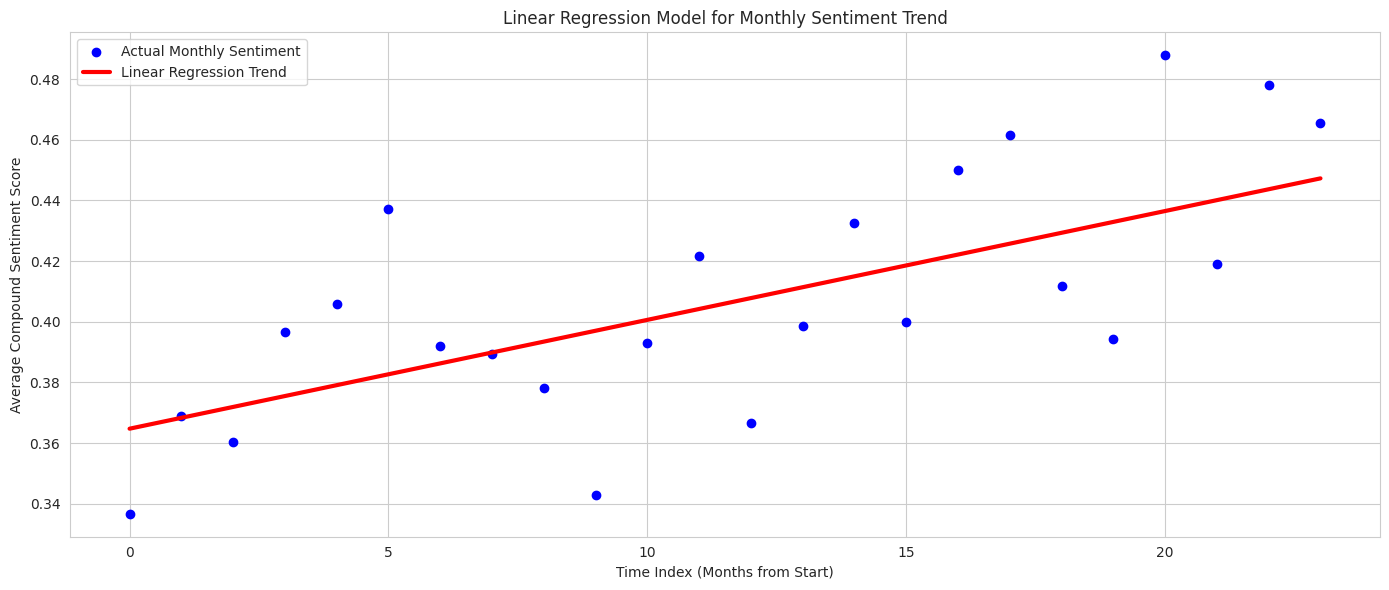

In [10]:
# Prepare data for modeling: create a numerical time index
monthly_sentiment['time_index'] = np.arange(len(monthly_sentiment))

X = monthly_sentiment[['time_index']]
y = monthly_sentiment['Average_Sentiment']

# Split data (use shuffle=False for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42 if len(X) > 1 else None)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for plotting the full trend line
y_all_pred = model.predict(X)

# Evaluate the model
y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Linear Regression Model Performance (on Test Set):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Trend Equation: Average Sentiment = ({model.coef_[0]:.4f} * Time Index) + {model.intercept_:.4f}")

# Plotting the Linear Regression Trend
plt.figure(figsize=(14, 6))
plt.scatter(X['time_index'], y, color='blue', label='Actual Monthly Sentiment')
plt.plot(X['time_index'], y_all_pred, color='red', linewidth=3, label='Linear Regression Trend')
plt.title('Linear Regression Model for Monthly Sentiment Trend')
plt.xlabel('Time Index (Months from Start)')
plt.ylabel('Average Compound Sentiment Score')
plt.legend()
plt.tight_layout()
plt.savefig('sentiment_linear_regression.png')
plt.show()